In [ ]:
import numpy as np
import time
from keras.models import load_model
from solver_backtracking import solve_backtrack, Step
from utils import evaluate_solution

In [26]:
class HybridSudokuSolver:
    def __init__(self, model_path, confidence_threshold=0.95):
        self.model = load_model(model_path)
        self.confidence_threshold = confidence_threshold
    
    def is_valid_move(self, board, row, col, num):
        """Check if a move is valid (doesn't violate Sudoku rules)"""
        if num == 0:
            return True
            
        # Check row
        if num in board[row, :]:
            return False
        
        # Check column
        if num in board[:, col]:
            return False
        
        # Check 3x3 box
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        box = board[box_row:box_row+3, box_col:box_col+3]
        if num in box:
            return False
        
        return True
    
    def print_board(self, board, title="Board"):
        """Print the sudoku board in a readable format"""
        print(f"\n{title}:")
        print("-" * 25)
        for i in range(9):
            if i % 3 == 0 and i != 0:
                print("-" * 25)
            row_str = ""
            for j in range(9):
                if j % 3 == 0 and j != 0:
                    row_str += "| "
                cell_value = board[i, j]
                row_str += f"{cell_value if cell_value != 0 else '.'} "
            print(row_str)
        print("-" * 25)
    
    def get_model_predictions(self, board):
        """Get model predictions for the current board state"""
        # Normalize input
        board_norm = board.astype(np.float32) / 9.0 - 0.5
        input_board = board_norm.reshape(1, 9, 9, 1)
        
        # Get predictions
        pred = self.model.predict(input_board, verbose=0)
        
        # Get predicted digits and their probabilities
        predicted_digits = np.argmax(pred[0], axis=-1) + 1
        probabilities = np.max(pred[0], axis=-1)
        
        return predicted_digits, probabilities
    
    def solve_with_cnn_first(self, puzzle, true_solution):
        """Use CNN for high-confidence predictions, then backtracking for the rest"""
        original_board = np.array(puzzle, dtype=int)
        true_solution = np.array(true_solution, dtype=int)
        
        print("=" * 60)
        print("HYBRID SUDOKU SOLVER: CNN + BACKTRACKING")
        print("=" * 60)
        
        # Step 1: Run CNN and get high-confidence predictions
        print("\n1. RUNNING CNN PREDICTIONS...")
        cnn_start_time = time.time()
        
        predicted_digits, probabilities = self.get_model_predictions(original_board)
        cnn_partial_board = original_board.copy()
        
        # Only fill cells where CNN has high confidence AND the cell is empty AND the move is valid
        empty_mask = original_board == 0
        high_confidence_mask = probabilities > self.confidence_threshold
        cells_to_fill = empty_mask & high_confidence_mask
        
        print(f"CNN confidence threshold: {self.confidence_threshold}")
        print(f"High-confidence predictions: {np.sum(cells_to_fill)} cells")
        
        # Count valid vs invalid high-confidence predictions
        valid_predictions = 0
        invalid_predictions = 0
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    predicted_value = predicted_digits[i, j]
                    if self.is_valid_move(cnn_partial_board, i, j, predicted_value):
                        cnn_partial_board[i, j] = predicted_value
                        valid_predictions += 1
                    else:
                        # Leave invalid predictions as 0 (don't fill them)
                        invalid_predictions += 1
                        cells_to_fill[i, j] = False  # Remove from filled count
        
        cnn_time = time.time() - cnn_start_time
        
        # Calculate REAL accuracy (against true solution, not just validity)
        cnn_filled_cells = np.sum(cells_to_fill)
        cnn_correct_predictions = 0
        
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j]:
                    if cnn_partial_board[i, j] == true_solution[i, j]:
                        cnn_correct_predictions += 1
        
        cnn_accuracy = cnn_correct_predictions / cnn_filled_cells if cnn_filled_cells > 0 else 0.0
        
        self.print_board(original_board, "ORIGINAL PUZZLE")
        self.print_board(cnn_partial_board, "AFTER CNN (HIGH-CONFIDENCE + VALID PREDICTIONS)")
        
        print(f"\nCNN RESULTS:")
        print(f"Time taken: {cnn_time:.4f} seconds")
        print(f"High-confidence cells found: {valid_predictions + invalid_predictions}")
        print(f"  Valid predictions: {valid_predictions}")
        print(f"  Invalid predictions: {invalid_predictions} (not filled)")
        print(f"Cells actually filled by CNN: {cnn_filled_cells}")
        print(f"CNN prediction accuracy: {cnn_accuracy * 100:.2f}%")
        print(f"Remaining empty cells: {np.sum(cnn_partial_board == 0)}")
        
        # Check if CNN solved it completely
        if np.array_equal(cnn_partial_board, true_solution):
            print("\n🎉 CNN SOLVED THE PUZZLE COMPLETELY!")
            return cnn_partial_board, cnn_time, 0, cnn_accuracy, 1.0
        
        # Step 2: Use backtracking for remaining empty cells
        remaining_empty = np.sum(cnn_partial_board == 0)
        print(f"\n2. RUNNING BACKTRACKING FOR {remaining_empty} REMAINING CELLS...")
        backtrack_start_time = time.time()
        
        # Use backtracking to solve remaining cells
        backtrack_board = cnn_partial_board.copy()
        steps = []
        
        success = solve_backtrack(backtrack_board, steps)
        backtrack_time = time.time() - backtrack_start_time
        
        if success:
            # Final evaluation
            final_empty_acc, final_all_acc = evaluate_solution(backtrack_board, original_board, true_solution)
            
            self.print_board(backtrack_board, "FINAL SOLUTION (AFTER BACKTRACKING)")
            
            print(f"\nBACKTRACKING RESULTS:")
            print(f"Time taken: {backtrack_time:.4f} seconds")
            print(f"Number of backtracking steps: {len(steps)}")
            print(f"Remaining cells solved correctly: {final_empty_acc * 100:.2f}%")
            print(f"Final all cells accuracy: {final_all_acc * 100:.2f}%")
            
            # Verify final solution
            if np.array_equal(backtrack_board, true_solution):
                print("🎉 PUZZLE SOLVED CORRECTLY!")
            else:
                print("❌ Final solution does not match expected result")
                print("Expected solution:")
                self.print_board(true_solution, "EXPECTED SOLUTION")
            
            return backtrack_board, cnn_time, backtrack_time, cnn_accuracy, final_all_acc
        
        else:
            print("❌ Backtracking failed to solve the puzzle")
            return None, cnn_time, backtrack_time, cnn_accuracy, 0.0

In [27]:
if __name__ == "__main__":
    import os
    from keras import saving
    
    # Load model
    cwd = os.getcwd()
    #model_path = os.path.join(cwd, "model", "sudoku_cnn_512_filters")
    model_path = os.path.join(cwd, "model", "sudoku_cnn_256_filters")
    
    try:
        solver = HybridSudokuSolver(model_path, confidence_threshold=0.98)
        
        # Test with easy puzzle
        
        easy_puzzle = [
            [5,3,0, 0,7,0, 0,0,0],
            [6,0,0, 1,9,5, 0,0,0],
            [0,9,8, 0,0,0, 0,6,0],

            [8,0,0, 0,6,0, 0,0,3],
            [4,0,0, 8,0,3, 0,0,1],
            [7,0,0, 0,2,0, 0,0,6],

            [0,6,0, 0,0,0, 2,8,0],
            [0,0,0, 4,1,9, 0,0,5],
            [0,0,0, 0,8,0, 0,7,9]
        ]

        easy_solution = [
            [5,3,4, 6,7,8, 9,1,2],
            [6,7,2, 1,9,5, 3,4,8],
            [1,9,8, 3,4,2, 5,6,7],

            [8,5,9, 7,6,1, 4,2,3],
            [4,2,6, 8,5,3, 7,9,1],
            [7,1,3, 9,2,4, 8,5,6],

            [9,6,1, 5,3,7, 2,8,4],
            [2,8,7, 4,1,9, 6,3,5],
            [3,4,5, 2,8,6, 1,7,9]
        ]
        print("🧪 TESTING MEDIUM PUZZLE:")
        result, cnn_time, backtrack_time, cnn_acc, final_acc = solver.solve_with_cnn_first(
            easy_puzzle, easy_solution
        )
        
        print(f"\n📊 SUMMARY FOR EASY PUZZLE:")
        print(f"CNN Time: {cnn_time:.4f}s")
        print(f"Backtracking Time: {backtrack_time:.4f}s")
        print(f"Total Time: {cnn_time + backtrack_time:.4f}s")
        print(f"CNN Prediction Accuracy: {cnn_acc * 100:.2f}%")
        print(f"Final Accuracy: {final_acc * 100:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

🧪 TESTING MEDIUM PUZZLE:
HYBRID SUDOKU SOLVER: CNN + BACKTRACKING

1. RUNNING CNN PREDICTIONS...
CNN confidence threshold: 0.98
High-confidence predictions: 3 cells

ORIGINAL PUZZLE:
-------------------------
5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
-------------------------
8 . . | . 6 . | . . 3 
4 . . | 8 . 3 | . . 1 
7 . . | . 2 . | . . 6 
-------------------------
. 6 . | . . . | 2 8 . 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 
-------------------------

AFTER CNN (HIGH-CONFIDENCE + VALID PREDICTIONS):
-------------------------
5 3 . | . 7 . | . . . 
6 . . | 1 9 5 | . . . 
. 9 8 | . . . | . 6 . 
-------------------------
8 . . | . 6 . | . . 3 
4 . . | 8 5 3 | . . 1 
7 . . | . 2 . | . . 6 
-------------------------
. 6 . | . . 7 | 2 8 4 
. . . | 4 1 9 | . . 5 
. . . | . 8 . | . 7 9 
-------------------------

CNN RESULTS:
Time taken: 2.7089 seconds
High-confidence cells found: 3
  Valid predictions: 3
  Invalid predictions: 0 (not filled)
Cells actual

In [ ]:
if __name__ == "__main__":
    import os
    from keras import saving
    
    # Load model
    cwd = os.getcwd()
    #model_path = os.path.join(cwd, "model", "sudoku_cnn_512_filters")
    model_path = os.path.join(cwd, "model", "sudoku_cnn_256_filters")
    
    try:
        solver = HybridSudokuSolver(model_path, confidence_threshold=0.98)
        
        # Test with medium puzzle
        medium_puzzle = [
            [0,0,0, 2,6,0, 7,0,1],
            [6,8,0, 0,7,0, 0,9,0],
            [1,9,0, 0,0,4, 5,0,0],
            [8,2,0, 1,0,0, 0,4,0],
            [0,0,4, 6,0,2, 9,0,0],
            [0,5,0, 0,0,3, 0,2,8],
            [0,0,9, 3,0,0, 0,7,4],
            [0,4,0, 0,5,0, 0,3,6],
            [7,0,3, 0,1,8, 0,0,0]
        ]

        medium_solution = [
            [4,3,5, 2,6,9, 7,8,1],
            [6,8,2, 5,7,1, 4,9,3],
            [1,9,7, 8,3,4, 5,6,2],
            [8,2,6, 1,9,5, 3,4,7],
            [3,7,4, 6,8,2, 9,1,5],
            [9,5,1, 7,4,3, 6,2,8],
            [5,1,9, 3,2,6, 8,7,4],
            [2,4,8, 9,5,7, 1,3,6],
            [7,6,3, 4,1,8, 2,5,9]
        ]
        
        print("🧪 TESTING MEDIUM PUZZLE:")
        result, cnn_time, backtrack_time, cnn_acc, final_acc = solver.solve_with_cnn_first(
            medium_puzzle, medium_solution
        )
        
        print(f"\n📊 SUMMARY FOR MEDIUM PUZZLE:")
        print(f"CNN Time: {cnn_time:.4f}s")
        print(f"Backtracking Time: {backtrack_time:.4f}s")
        print(f"Total Time: {cnn_time + backtrack_time:.4f}s")
        print(f"CNN Prediction Accuracy: {cnn_acc * 100:.2f}%")
        print(f"Final Accuracy: {final_acc * 100:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

🧪 TESTING MEDIUM PUZZLE:
HYBRID SUDOKU SOLVER: CNN + BACKTRACKING

1. RUNNING CNN PREDICTIONS...
CNN confidence threshold: 0.98
High-confidence predictions: 22 cells

ORIGINAL PUZZLE:
-------------------------
. . . | 2 6 . | 7 . 1 
6 8 . | . 7 . | . 9 . 
1 9 . | . . 4 | 5 . . 
-------------------------
8 2 . | 1 . . | . 4 . 
. . 4 | 6 . 2 | 9 . . 
. 5 . | . . 3 | . 2 8 
-------------------------
. . 9 | 3 . . | . 7 4 
. 4 . | . 5 . | . 3 6 
7 . 3 | . 1 8 | . . . 
-------------------------

AFTER CNN (HIGH-CONFIDENCE + VALID PREDICTIONS):
-------------------------
4 3 5 | 2 6 9 | 7 8 1 
6 8 . | 5 7 . | . 9 . 
1 9 . | 8 3 4 | 5 6 . 
-------------------------
8 2 . | 1 9 . | . 4 . 
3 . 4 | 6 8 2 | 9 . . 
9 5 . | . 4 3 | . 2 8 
-------------------------
. . 9 | 3 2 6 | 8 7 4 
2 4 . | . 5 . | . 3 6 
7 6 3 | 4 1 8 | 2 5 . 
-------------------------

CNN RESULTS:
Time taken: 1.4152 seconds
High-confidence cells found: 22
  Valid predictions: 22
  Invalid predictions: 0 (not filled)
Cells act

In [ ]:
if __name__ == "__main__":
    import os
    from keras import saving
    
    # Load model
    cwd = os.getcwd()
    #model_path = os.path.join(cwd, "model", "sudoku_cnn_512_filters")
    model_path = os.path.join(cwd, "model", "sudoku_cnn_256_filters")
    
    try:
        solver = HybridSudokuSolver(model_path, confidence_threshold=0.98)
        
        # Test with hard puzzle
        hard_puzzle = [
            [0,0,0, 2,9,0, 0,0,0],
            [0,4,0, 1,0,0, 0,0,0],
            [0,2,0, 0,7,0, 0,8,1],
            [0,7,0, 4,2,0, 0,9,0],
            [0,0,0, 0,0,0, 0,3,0],
            [0,0,5, 0,0,6, 0,0,0],
            [0,0,0, 9,4,0, 0,2,3],
            [0,0,0, 0,0,3, 0,0,0],
            [0,0,1, 0,0,0, 8,0,0]
        ]

        hard_solution = [
            [1,6,8, 2,9,5, 3,4,7],
            [3,4,7, 1,6,8, 9,5,2],
            [5,2,9, 3,7,4, 6,8,1],
            [6,7,3, 4,2,1, 5,9,8],
            [2,1,4, 5,8,9, 7,3,6],
            [9,8,5, 7,3,6, 2,1,4],
            [8,5,6, 9,4,7, 1,2,3],
            [7,9,2, 8,1,3, 4,6,5],
            [4,3,1, 6,5,2, 8,7,9]
        ]
        
        print("🧪 TESTING MEDIUM PUZZLE:")
        result, cnn_time, backtrack_time, cnn_acc, final_acc = solver.solve_with_cnn_first(
            hard_puzzle, hard_solution
        )
        
        print(f"\n📊 SUMMARY FOR HARD PUZZLE:")
        print(f"CNN Time: {cnn_time:.4f}s")
        print(f"Backtracking Time: {backtrack_time:.4f}s")
        print(f"Total Time: {cnn_time + backtrack_time:.4f}s")
        print(f"CNN Prediction Accuracy: {cnn_acc * 100:.2f}%")
        print(f"Final Accuracy: {final_acc * 100:.2f}%")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

Starting benchmark...
Testing 256_filters on easy puzzle 1...
Testing 512_filters on easy puzzle 1...
Testing 256_filters on medium puzzle 1...
Testing 512_filters on medium puzzle 1...
Testing 256_filters on hard puzzle 1...
Testing 512_filters on hard puzzle 1...
Results saved to sudoku_benchmark_results.csv


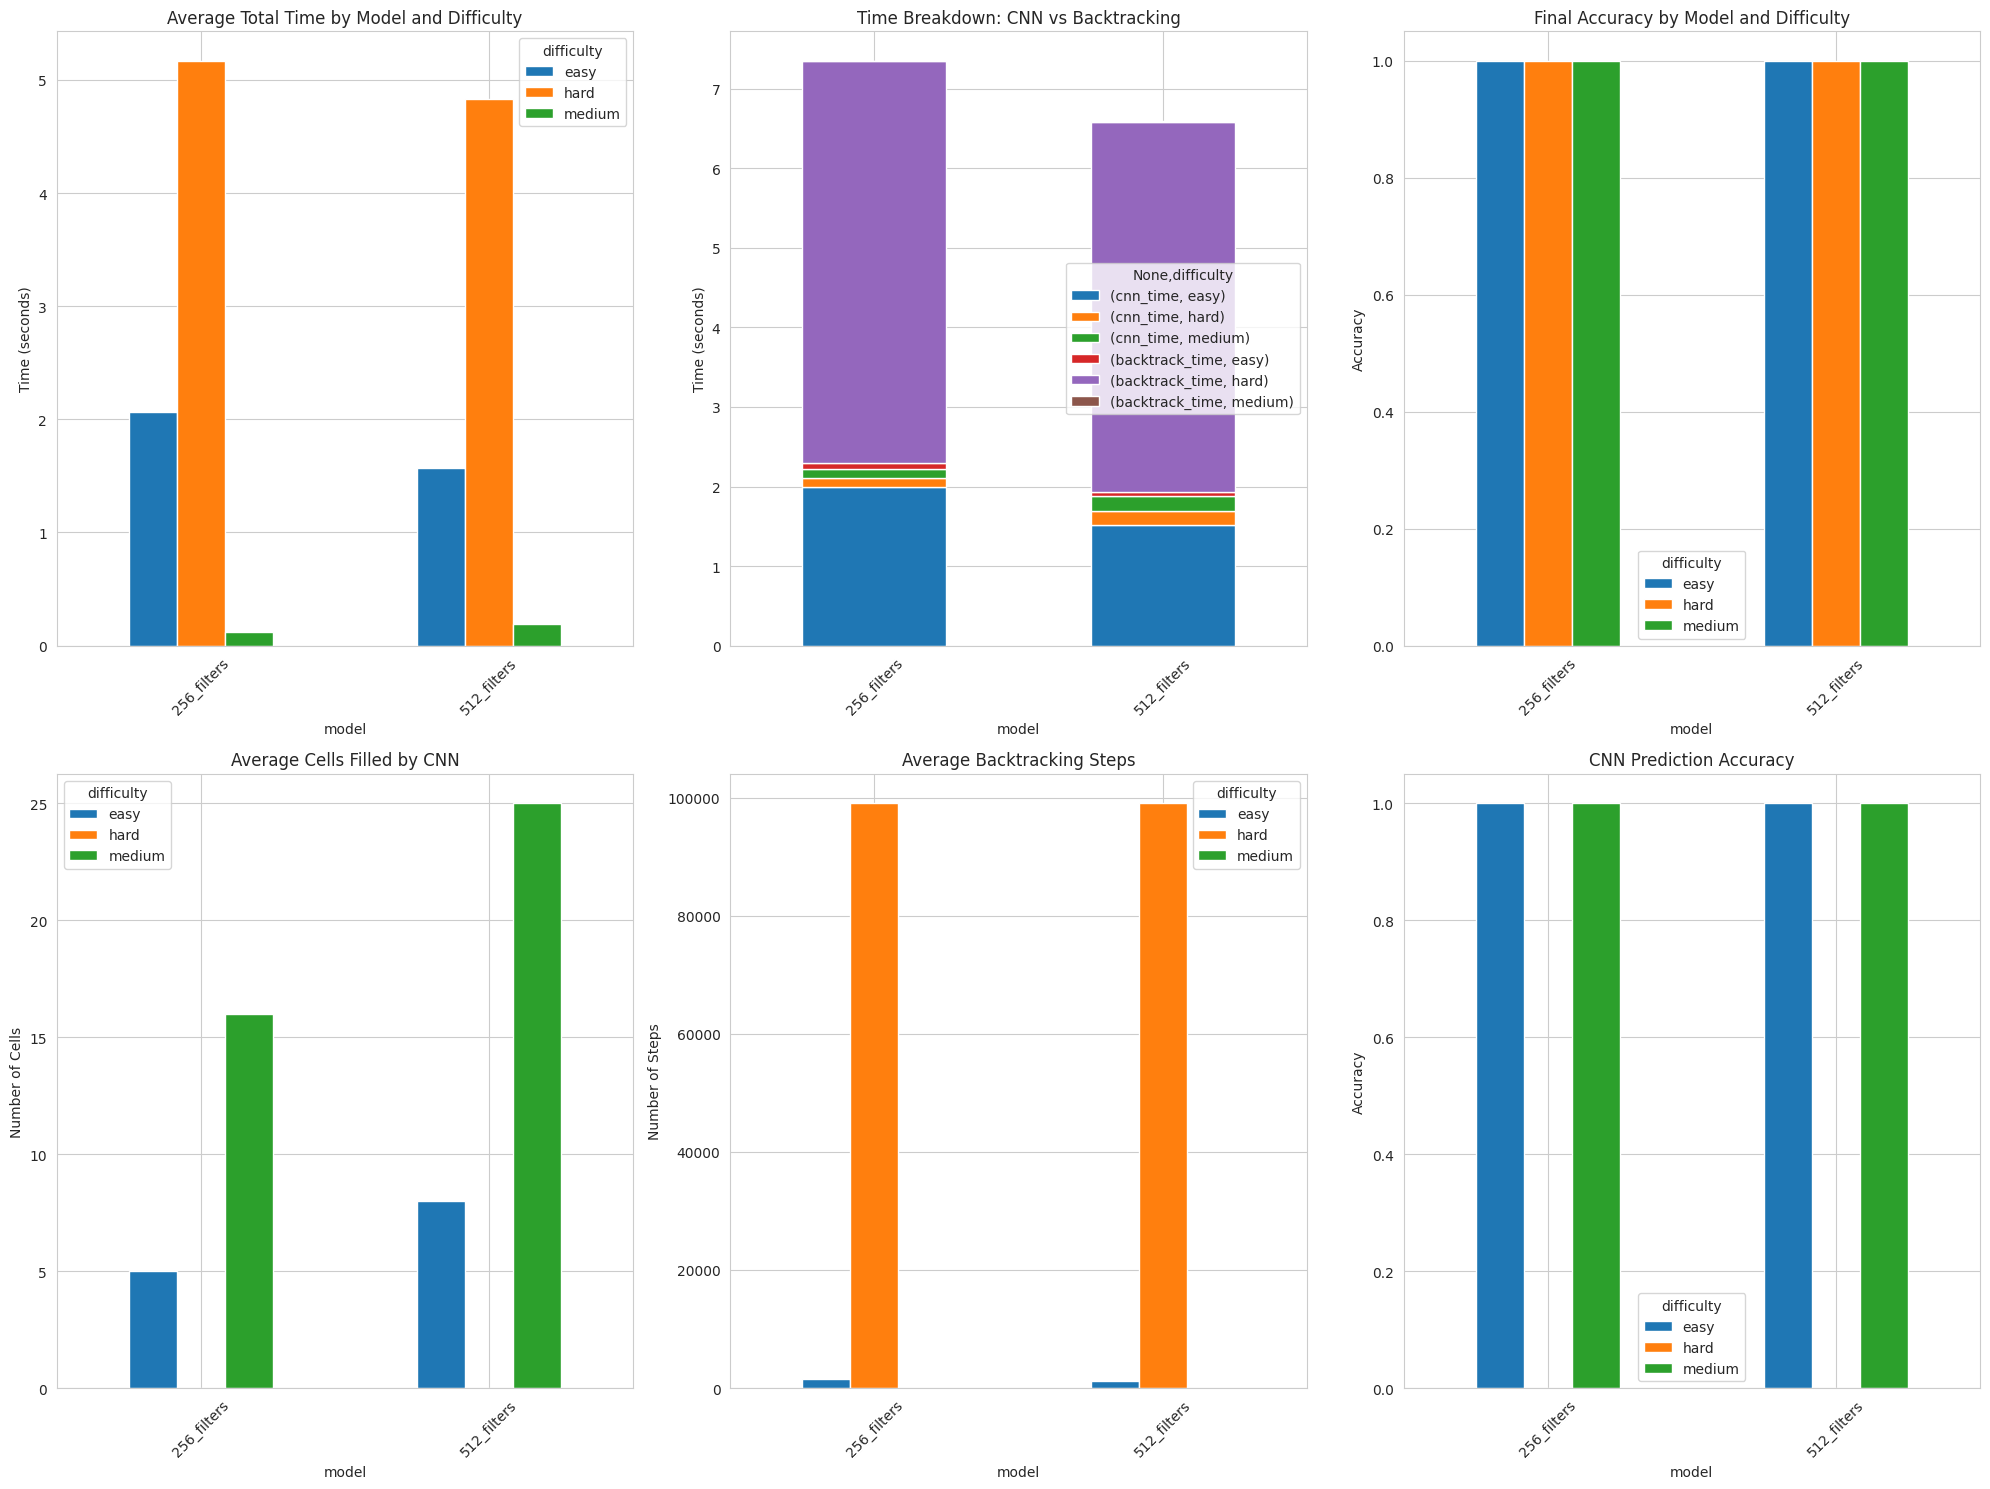

SUDOKU SOLVER BENCHMARK SUMMARY
                       total_time     final_accuracy cnn_accuracy  \
                             mean std           mean         mean   
model       difficulty                                              
256_filters easy           2.0632 NaN            1.0          1.0   
            hard           5.1704 NaN            1.0          0.0   
            medium         0.1210 NaN            1.0          1.0   
512_filters easy           1.5705 NaN            1.0          1.0   
            hard           4.8292 NaN            1.0          0.0   
            medium         0.1901 NaN            1.0          1.0   

                       cnn_cells_filled backtrack_steps  
                                   mean            mean  
model       difficulty                                   
256_filters easy                    5.0          1546.0  
            hard                    0.0         99056.0  
            medium                 16.0            35.0 

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class SudokuBenchmark:
    def __init__(self, model_256_path, model_512_path):
        self.model_256 = load_model(model_256_path)
        self.model_512 = load_model(model_512_path)
        self.results = []
    
    def is_valid_move(self, board, row, col, num):
        """Check if a move is valid"""
        if num == 0:
            return True
            
        if num in board[row, :]:
            return False
        
        if num in board[:, col]:
            return False
        
        box_row, box_col = 3 * (row // 3), 3 * (col // 3)
        box = board[box_row:box_row+3, box_col:box_col+3]
        if num in box:
            return False
        
        return True
    
    def run_hybrid_solver(self, model, puzzle, true_solution, confidence_threshold=0.95):
        """Run hybrid solver and return metrics"""
        original_board = np.array(puzzle, dtype=int)
        true_solution = np.array(true_solution, dtype=int)
        
        # CNN phase
        cnn_start = time.time()
        board_norm = original_board.astype(np.float32) / 9.0 - 0.5
        input_board = board_norm.reshape(1, 9, 9, 1)
        pred = model.predict(input_board, verbose=0)
        predicted_digits = np.argmax(pred[0], axis=-1) + 1
        probabilities = np.max(pred[0], axis=-1)
        cnn_time = time.time() - cnn_start
        
        # Apply high-confidence predictions
        cnn_board = original_board.copy()
        empty_mask = original_board == 0
        high_conf_mask = probabilities > confidence_threshold
        cells_to_fill = empty_mask & high_conf_mask
        
        valid_predictions = 0
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j] and self.is_valid_move(cnn_board, i, j, predicted_digits[i, j]):
                    cnn_board[i, j] = predicted_digits[i, j]
                    valid_predictions += 1
        
        # Calculate CNN accuracy
        cnn_correct = 0
        for i in range(9):
            for j in range(9):
                if cells_to_fill[i, j] and cnn_board[i, j] != 0:
                    if cnn_board[i, j] == true_solution[i, j]:
                        cnn_correct += 1
        
        cnn_accuracy = cnn_correct / valid_predictions if valid_predictions > 0 else 0
        remaining_cells = np.sum(cnn_board == 0)
        
        # Backtracking phase
        if remaining_cells > 0:
            backtrack_start = time.time()
            backtrack_board = cnn_board.copy()
            steps = []
            success = solve_backtrack(backtrack_board, steps)
            backtrack_time = time.time() - backtrack_start
            
            if success:
                final_empty_acc, final_all_acc = evaluate_solution(backtrack_board, original_board, true_solution)
                return {
                    'success': True,
                    'cnn_time': cnn_time,
                    'backtrack_time': backtrack_time,
                    'total_time': cnn_time + backtrack_time,
                    'cnn_accuracy': cnn_accuracy,
                    'final_accuracy': final_all_acc,
                    'cnn_cells_filled': valid_predictions,
                    'remaining_cells': remaining_cells,
                    'backtrack_steps': len(steps)
                }
        
        return {'success': False}
    
    def benchmark_models(self, puzzles, solutions, difficulties, confidence_threshold=0.95):
        """Benchmark both models on multiple puzzles"""
        models = {
            '256_filters': self.model_256,
            '512_filters': self.model_512
        }
        
        for difficulty, puzzle_list, solution_list in zip(difficulties, puzzles, solutions):
            for i, (puzzle, true_solution) in enumerate(zip(puzzle_list, solution_list)):
                for model_name, model in models.items():
                    print(f"Testing {model_name} on {difficulty} puzzle {i+1}...")
                    
                    result = self.run_hybrid_solver(model, puzzle, true_solution, confidence_threshold)
                    
                    if result['success']:
                        self.results.append({
                            'model': model_name,
                            'difficulty': difficulty,
                            'puzzle_id': i + 1,
                            'cnn_time': result['cnn_time'],
                            'backtrack_time': result['backtrack_time'],
                            'total_time': result['total_time'],
                            'cnn_accuracy': result['cnn_accuracy'],
                            'final_accuracy': result['final_accuracy'],
                            'cnn_cells_filled': result['cnn_cells_filled'],
                            'remaining_cells': result['remaining_cells'],
                            'backtrack_steps': result['backtrack_steps']
                        })
        
        return pd.DataFrame(self.results)
    
    def create_visualizations(self, df):
        """Create comprehensive visualizations"""
        sns.set_style("whitegrid")
        plt.figure(figsize=(20, 15))
        
        # 1. Time comparison by model and difficulty
        plt.subplot(2, 3, 1)
        time_data = df.groupby(['model', 'difficulty'])['total_time'].mean().unstack()
        time_data.plot(kind='bar', ax=plt.gca())
        plt.title('Average Total Time by Model and Difficulty')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        
        # 2. CNN vs Backtracking time breakdown
        plt.subplot(2, 3, 2)
        time_breakdown = df.groupby(['model', 'difficulty'])[['cnn_time', 'backtrack_time']].mean().unstack()
        time_breakdown.plot(kind='bar', stacked=True, ax=plt.gca())
        plt.title('Time Breakdown: CNN vs Backtracking')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        
        # 3. Accuracy comparison
        plt.subplot(2, 3, 3)
        accuracy_data = df.groupby(['model', 'difficulty'])['final_accuracy'].mean().unstack()
        accuracy_data.plot(kind='bar', ax=plt.gca())
        plt.title('Final Accuracy by Model and Difficulty')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        # 4. Cells filled by CNN
        plt.subplot(2, 3, 4)
        cells_data = df.groupby(['model', 'difficulty'])['cnn_cells_filled'].mean().unstack()
        cells_data.plot(kind='bar', ax=plt.gca())
        plt.title('Average Cells Filled by CNN')
        plt.ylabel('Number of Cells')
        plt.xticks(rotation=45)
        
        # 5. Backtracking steps
        plt.subplot(2, 3, 5)
        steps_data = df.groupby(['model', 'difficulty'])['backtrack_steps'].mean().unstack()
        steps_data.plot(kind='bar', ax=plt.gca())
        plt.title('Average Backtracking Steps')
        plt.ylabel('Number of Steps')
        plt.xticks(rotation=45)
        
        # 6. CNN Accuracy
        plt.subplot(2, 3, 6)
        cnn_acc_data = df.groupby(['model', 'difficulty'])['cnn_accuracy'].mean().unstack()
        cnn_acc_data.plot(kind='bar', ax=plt.gca())
        plt.title('CNN Prediction Accuracy')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig('sudoku_benchmark_results.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def print_summary_statistics(self, df):
        """Print comprehensive summary statistics"""
        print("=" * 80)
        print("SUDOKU SOLVER BENCHMARK SUMMARY")
        print("=" * 80)
        
        summary = df.groupby(['model', 'difficulty']).agg({
            'total_time': ['mean', 'std'],
            'final_accuracy': 'mean',
            'cnn_accuracy': 'mean',
            'cnn_cells_filled': 'mean',
            'backtrack_steps': 'mean'
        }).round(4)
        
        print(summary)
        print("\n" + "=" * 80)
        
        # Best performing model overall
        best_model = df.groupby('model')['final_accuracy'].mean().idxmax()
        print(f"Best overall model: {best_model}")
        
        # Fastest model
        fastest_model = df.groupby('model')['total_time'].mean().idxmin()
        print(f"Fastest model: {fastest_model}")

# Define your test puzzles by difficulty
def get_test_puzzles():
    """Return puzzles organized by difficulty"""
    easy_puzzles = [
        [
            [5,3,0, 0,7,0, 0,0,0],
            [6,0,0, 1,9,5, 0,0,0],
            [0,9,8, 0,0,0, 0,6,0],
            [8,0,0, 0,6,0, 0,0,3],
            [4,0,0, 8,0,3, 0,0,1],
            [7,0,0, 0,2,0, 0,0,6],
            [0,6,0, 0,0,0, 2,8,0],
            [0,0,0, 4,1,9, 0,0,5],
            [0,0,0, 0,8,0, 0,7,9]
        ]
    ]
    
    easy_solutions = [
        [
            [5,3,4, 6,7,8, 9,1,2],
            [6,7,2, 1,9,5, 3,4,8],
            [1,9,8, 3,4,2, 5,6,7],
            [8,5,9, 7,6,1, 4,2,3],
            [4,2,6, 8,5,3, 7,9,1],
            [7,1,3, 9,2,4, 8,5,6],
            [9,6,1, 5,3,7, 2,8,4],
            [2,8,7, 4,1,9, 6,3,5],
            [3,4,5, 2,8,6, 1,7,9]
        ]
    ]
    
    medium_puzzles = [
        [
            [0,0,0, 2,6,0, 7,0,1],
            [6,8,0, 0,7,0, 0,9,0],
            [1,9,0, 0,0,4, 5,0,0],
            [8,2,0, 1,0,0, 0,4,0],
            [0,0,4, 6,0,2, 9,0,0],
            [0,5,0, 0,0,3, 0,2,8],
            [0,0,9, 3,0,0, 0,7,4],
            [0,4,0, 0,5,0, 0,3,6],
            [7,0,3, 0,1,8, 0,0,0]
        ]
    ]
    
    medium_solutions = [
        [
            [4,3,5, 2,6,9, 7,8,1],
            [6,8,2, 5,7,1, 4,9,3],
            [1,9,7, 8,3,4, 5,6,2],
            [8,2,6, 1,9,5, 3,4,7],
            [3,7,4, 6,8,2, 9,1,5],
            [9,5,1, 7,4,3, 6,2,8],
            [5,1,9, 3,2,6, 8,7,4],
            [2,4,8, 9,5,7, 1,3,6],
            [7,6,3, 4,1,8, 2,5,9]
        ]
    ]
    
    hard_puzzles = [
        [
            [8,0,0, 0,0,0, 0,0,0],
            [0,0,3, 6,0,0, 0,0,0],
            [0,7,0, 0,9,0, 2,0,0],
            [0,5,0, 0,0,7, 0,0,0],
            [0,0,0, 0,4,5, 7,0,0],
            [0,0,0, 1,0,0, 0,3,0],
            [0,0,1, 0,0,0, 0,6,8],
            [0,0,8, 5,0,0, 0,1,0],
            [0,9,0, 0,0,0, 4,0,0]
        ]
    ]
    
    hard_solutions = [
        [
            [8,1,2, 7,5,3, 6,4,9],
            [9,4,3, 6,8,2, 1,7,5],
            [6,7,5, 4,9,1, 2,8,3],
            [1,5,4, 2,3,7, 8,9,6],
            [3,6,9, 8,4,5, 7,2,1],
            [2,8,7, 1,6,9, 5,3,4],
            [5,2,1, 9,7,4, 3,6,8],
            [4,3,8, 5,2,6, 9,1,7],
            [7,9,6, 3,1,8, 4,5,2]
        ]
    ]
    
    return (
        [easy_puzzles, medium_puzzles, hard_puzzles],
        [easy_solutions, medium_solutions, hard_solutions],
        ['easy', 'medium', 'hard']
    )

# Run the benchmark
if __name__ == "__main__":
    import os
    
    # Update these paths to your actual model locations
    model_256_path = os.path.join(cwd, "model", "sudoku_cnn_256_filters")
    model_512_path = os.path.join(cwd, "model", "sudoku_cnn_512_filters")
    
    # Get test data
    puzzles, solutions, difficulties = get_test_puzzles()
    
    # Create benchmark instance
    benchmark = SudokuBenchmark(model_256_path, model_512_path)
    
    # Run benchmark
    print("Starting benchmark...")
    results_df = benchmark.benchmark_models(puzzles, solutions, difficulties, confidence_threshold=0.95)
    
    # Save results to CSV
    results_df.to_csv('sudoku_benchmark_results.csv', index=False)
    print("Results saved to sudoku_benchmark_results.csv")
    
    # Create visualizations
    benchmark.create_visualizations(results_df)
    
    # Print summary statistics
    benchmark.print_summary_statistics(results_df)
    
    # Additional detailed analysis
    print("\nDETAILED ANALYSIS:")
    print("=" * 50)
    
    # Model comparison
    model_comparison = results_df.groupby('model').agg({
        'total_time': 'mean',
        'final_accuracy': 'mean',
        'cnn_accuracy': 'mean'
    }).round(4)
    
    print("Overall Model Performance:")
    print(model_comparison)